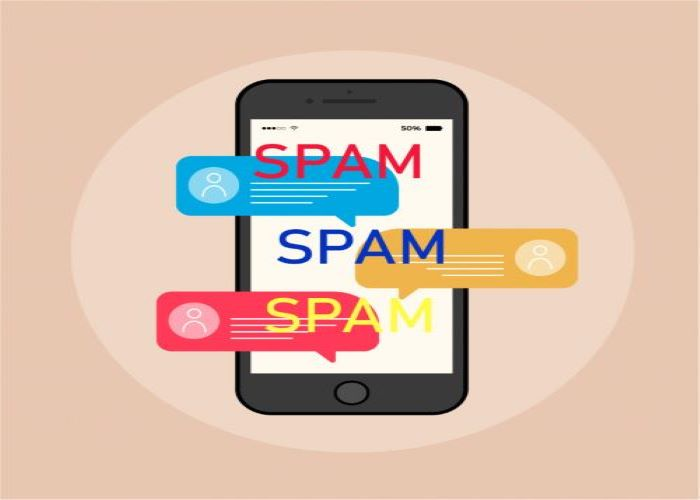

## Project: Building a Spam Filter with Naive Bayes

### Introduction:


In this project my goal will be to create a spam filter for text messages using Multinomial Naive Bayes Algorithm.
I will be using a dataset of 5,572 SMS messages that are already classified by humans. My end goal will be to have a working spam filter with a classification accuracy of 80% or more (if the text is spam or not).

The dataset was created by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). 

Note that due to the nature of spam messages, the dataset contains content that may be offensive to some users.

I will load in the dataset with pandas and begin to explore the dataset. 

In [133]:
import pandas as pd 

cell_texts = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])

cell_texts.info()
cell_texts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [134]:
print(cell_texts['Label'].value_counts())

print ('Percent of non spam text messages', round(4825/5572,2) *100)

ham     4825
spam     747
Name: Label, dtype: int64
Percent of non spam text messages 87.0


Notes: 

As we can see above we have a data set with no missing values. We only have 2 columns. A label column and an SMS column.
The __label column__ is split between __ham__ and __spam__. A funny way of the authors splitting the data between real text messages and spam texts. The __SMS column__ is literally the body of the text messgae received. 

Using the value counts function we can see that 87% of the texts were classified as non spam and 13% were listed as spam. 


### Creating a Training and Test Set:

Once the spam filter is created I will need to test it. So I will be splitting the dataset into 2 caterories:

* A training set will train the spam filter how to classify messages.
* A test set which will be used to test how good the spam filter is classifying text messages. 

80% of the dataset will be used for training and 20% for testing. 
The training set will have 4,458 messages.
The test set will have 1,114 messages.

To start I will randomize the dataset set to have a fair spread of ham and spam texts between my 2 sets. I will try to keep the spread of texts as close as possible to the original 87/13 split. 


In [135]:
training = cell_texts.sample(frac=1, random_state=1) #randomizing entire dataset 

training_text = training.iloc[0:4458].reset_index(drop=True)
test_set = training.iloc[4458:].reset_index(drop=True)

print (training_text.shape)
print (test_set.shape)

print(training_text['Label'].value_counts(normalize=True))
print(test_set['Label'].value_counts(normalize=True))

(4458, 2)
(1114, 2)
ham     0.86541
spam    0.13459
Name: Label, dtype: float64
ham     0.868043
spam    0.131957
Name: Label, dtype: float64


As we can see above we have a pretty good split between the two sets. This will be good as is to move forward. 

### Letter Case and Punctuation:

In this part I will be cleaning the __SMS__ column so it can be easier to detect words to classify an sms as spam or not. 
In the sample head I printed shows we have special characters and words captalized. I will need to remove all special characters and punctuations and have all words as lower case so the filter can accurately detect messages. 

In [136]:
training_text.head(10)

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...
5,ham,Ok i thk i got it. Then u wan me 2 come now or...
6,ham,I want kfc its Tuesday. Only buy 2 meals ONLY ...
7,ham,No dear i was sleeping :-P
8,ham,Ok pa. Nothing problem:-)
9,ham,Ill be there on &lt;#&gt; ok.


In [137]:
training_text['SMS'] = training_text['SMS'].str.lower()

print(training_text['SMS'])

0                            yep, by the pretty sculpture
1           yes, princess. are you going to make me moan?
2                              welp apparently he retired
3                                                 havent.
4       i forgot 2 ask ü all smth.. there's a card on ...
                              ...                        
4453    sorry, i'll call later in meeting any thing re...
4454    babe! i fucking love you too !! you know? fuck...
4455    u've been selected to stay in 1 of 250 top bri...
4456    hello my boytoy ... geeee i miss you already a...
4457                             wherre's my boytoy ? :-(
Name: SMS, Length: 4458, dtype: object


In [138]:
#removing special characters and extra spaces.

training_text['SMS'] = training_text['SMS'].str.replace('\W', ' ', regex=True)
training_text['SMS'] = training_text['SMS'].str.replace('  ', ' ', regex=True)
training_text['SMS'] = training_text['SMS'].str.replace('   ', ' ', regex=True)
training_text['SMS'] = training_text['SMS'].str.replace('    ', ' ', regex=True)
training_text['SMS']

0                             yep by the pretty sculpture
1             yes princess are you going to make me moan 
2                              welp apparently he retired
3                                                 havent 
4       i forgot 2 ask ü all smth  there s a card on d...
                              ...                        
4453    sorry i ll call later in meeting any thing rel...
4454    babe i fucking love you too  you know fuck it ...
4455    u ve been selected to stay in 1 of 250 top bri...
4456    hello my boytoy geeee i miss you already and i...
4457                                  wherre s my boytoy 
Name: SMS, Length: 4458, dtype: object

In [139]:
#checking a sample of text to see how it looks. 

training_text['SMS'].sample(20)


1851         anything lar then ü not going home 4 dinner 
1445                                                 ok  
213     every king was once a crying baby and every gr...
1133    brainless baby doll  d vehicle sariyag drive m...
1242    cant think of anyone with  spare room off  top...
2867    new textbuddy chat 2 horny guys in ur area 4 j...
1276    too late i said i have the website i didn t i ...
2986    leaving to qatar tonite in search of an opport...
1338                                  is ur lecture over 
3026    lol i would but despite these cramps i like be...
3973                   what number do u live at is it 11 
2138     okay i ve seen it so i should pick it on friday 
3866                          pick ur fone up now u dumb 
1897    if you aren t here in the next  lt  gt  hours ...
75      i couldn t say no as he is a dying man and i f...
3620    ok but tell me half an hr b4 u come i need 2 p...
1258                       do you want bold 2 or bb torch
1483          

Now that some cleaning has been done on the __SMS__ column I can move forward with creating a vocabulary. The training dataset is pretty large so hopefully no further cleaning will need to be done. I want to keep the accuracy of the spam filter above 80% so I may need to come back to the cleaning portion. 

### Creating the Vocabulary:

Now I will create a vocabulary for the messages in the training set. The vocabulary will be a Python list containing all the unique words across all messages, where each word is represented as a string. What I eventually want is to have each unique word to be its own column in a dataframe. 

In [140]:
training_text['SMS'] = training_text['SMS'].str.split()

vocabulary = []

for word in training_text['SMS']: 
    for v in word: 
        vocabulary.append(v)

#removing duplicates        
vocabulary= set(vocabulary)   
vocabulary = list(vocabulary)

len(vocabulary)

7783

In [141]:
print(vocabulary)

['hold', 'comuk', 'gotany', 'madurai', 'foley', '050703', '14', 'wanting', 'buddys', 'mushy', 'dem', 'completes', 'positive', 'pale', 'behave', '4403ldnw1a7rw18', '09066382422', 'destiny', 'wish', 'hits', 'stories', 'professors', '150pm', 'laundry', '____', 'pounds', 'ternal', 'common', 'rs', '113', 'biatch', '000', 'whatsup', 'push', 'major', 'dieting', 'unni', 'cttargg', 'young', 'supports', 'last', 'umma', 'clip', 'snogs', 'century', 'car', 'fumbling', 'housing', 'oncall', '4w', 'boatin', '50gbp', 'r836', 'stay', 'sambar', 'is', 'si', 'services', 'ms', '32000', 'implications', 'garden', 'passionate', 'as', 'eightish', 'driver', 'promises', 'starshine', 'merely', 'necesity', 'vettam', 'havebeen', 'loveme', '7th', 'up4', '087123002209am', 'siguviri', 'tee', 'audition', 'elaborating', 'moving', 'avent', 'toxic', 'squeeeeeze', 'jeremiah', 'braved', 'cutie', '09056242159', 'breaking', 'inlude', 'news', 'perfume', 'atlast', '83600', 'jjc', '5p', 'secretly', 'youuuuu', 'sentence', 'sweatte

After creating the vocabulary I have 7,783 unique strings. Scrolling through the list I can see some words are still combined and alot of misspelled words. This makes sense that people could generally not care too much about their grammar or spelling when texting someone. 

### Completing the training set: 

Now I will create a dictionary that eventually will be converted into a dataframe with all the unique words as their own column. Doing this will create columns with elements showing how many times a certain word is used in a text message.  Then I will combine that dataframe with the training text dataframe.

In [142]:
word_counts_per_sms = {unique_word: [0] * len(training_text['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_text['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1
        
word_counts = pd.DataFrame(word_counts_per_sms)     

print(word_counts.tail())
print(word_counts['payment'].value_counts())

      hold  comuk  gotany  madurai  foley  050703  14  wanting  buddys  mushy  \
4453     0      0       0        0      0       0   0        0       0      0   
4454     0      0       0        0      0       0   0        0       0      0   
4455     0      0       0        0      0       0   0        0       0      0   
4456     0      0       0        0      0       0   0        0       0      0   
4457     0      0       0        0      0       0   0        0       0      0   

      ...  notifications  successful  women  downs  scammers  answered  \
4453  ...              0           0      0      0         0         0   
4454  ...              0           0      0      0         0         0   
4455  ...              0           0      0      0         0         0   
4456  ...              0           0      0      0         0         0   
4457  ...              0           0      0      0         0         0   

      cleared  payment  youphone  sure  
4453        0        0     

In [143]:
final_training_text = pd.concat([training_text, word_counts], axis=1)

final_training_text.head()

,Label,SMS,hold,comuk,gotany,madurai,foley,050703,14,wanting,...,notifications,successful,women,downs,scammers,answered,cleared,payment,youphone,sure
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Calculating Constants First:

Now since the dataframe is completed. I can move forward with creating the spam filter. First I will begin with calculating the constants first. I will need to use Naive Bayes algorithm to calculate. 

Calculate P(Spam) and P(Ham). 
Calculate NSpam, NHam, NVocabulary.
and initiate a variable named alpha with a value of 1 for Laplace smoothing.



In [144]:
#finding the spam and not spam

ham = final_training_text[final_training_text['Label'] == 'ham'].shape[0]
spam = final_training_text[final_training_text['Label'] == 'spam'].shape[0]
total_texts = final_training_text['Label'].shape[0]

print('Total Ham Texts:',ham)
print()
print('Total Spam Texts:',spam)
print()
print('Total Texts:',total_texts)

Total Ham Texts: 3858

Total Spam Texts: 600

Total Texts: 4458


In [145]:
p_ham = ham/total_texts
p_spam = spam/total_texts

print('Percentage of Ham:',p_ham)
print()
print('Percentage of Spam:',p_spam)

Percentage of Ham: 0.8654104979811574

Percentage of Spam: 0.13458950201884254


In [146]:
# finding NSpam, N Ham, and Nvocabulary by counting the words and creating alpha

a_ham = final_training_text[final_training_text['Label'] == 'ham']['SMS'].apply(len)

a_spam = final_training_text[final_training_text['Label'] == 'spam']['SMS'].apply(len)

n_ham = a_ham.sum()

n_spam = a_spam.sum()

n_vocabulary = len(vocabulary)

alpha = 1 #for laplace smoothing

print(n_ham)
print()
print(n_spam)
print()
print(n_vocabulary)

57237

15190

7783


Now that I created a few constants that I needed I will move forward with calculating the parameters. 

### Calculating Parameters:

The dataframe has 7,783 words in the vocabulary, which means I'll need to calculate a total of 15,566 probabilities. For each word, I'll need to calculate both P(Wi|Spam) and P(Wi|Ham).

I will need to incorporate this formula:

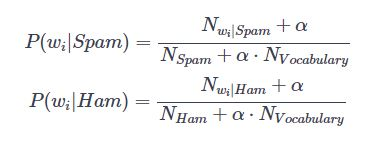

In [147]:
# lets start with making 2 dictionaries 

ham_dic = {unique_word:0 for unique_word in vocabulary}
spam_dic = {unique_word:0 for unique_word in vocabulary} 


#splitting the final training text dataframe into 2 seperate dataframes isolating spam from ham

ham_frame = final_training_text[final_training_text['Label'] == 'ham'].copy()
spam_frame = final_training_text[final_training_text['Label'] == 'spam'].copy()

#Iterating over the vocabulary for each word to calculate P(wi|Ham) 

for word in vocabulary: 
    nwi_ham = ham_frame[word].sum()
    apply_ham_formula = (nwi_ham + alpha) / ((n_ham + alpha) * n_vocabulary)
    ham_dic[word] = apply_ham_formula
    
    
#Iterating over the vocabulary for each word to calculate P(wi|Spam) 

for word in vocabulary: 
    nwi_spam = spam_frame[word].sum()
    apply_spam_formula = (nwi_spam + alpha) / ((n_spam + alpha) * n_vocabulary)
    spam_dic[word] = apply_spam_formula
    
print(len(ham_dic))
print(len(spam_dic))

7783
7783


### Classifying A New Message:

Now that I have completed the constants and parameters I can move forward with creating the spam filter function. 
Inside the spam filter function I will need to create the formulas for spam given message and ham given message. 
The formula looks like this: 



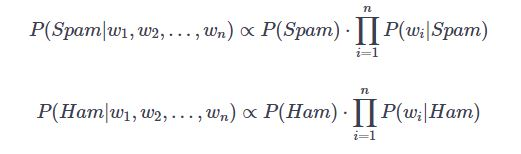

In [154]:
import re

def classify(message):
    #cleaning the Sms column
    message = re.sub('\W', ' ', message) 
    message = message.lower()
    message = message.split()
    
    #creating formula
    p_ham_given_message = p_ham 
    p_spam_given_message = p_spam
    
    #updates the values to detect spam or ham
    for word in message: 
        if word in ham_dic:
            p_ham_given_message *= ham_dic[word]
        
        if word in spam_dic:
            p_spam_given_message *= spam_dic[word]

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [156]:
# testing the function

test_a = 'WINNER!! This is the secret code to unlock the money: C3421.'
test_b = "Sounds good, Tom, then see u there"

classify(test_a)
classify(test_b)

P(Spam|message): 5.32218937227696e-59
P(Ham|message): 5.821370428319695e-62
Label: Spam
P(Spam|message): 2.5485202709195435e-51
P(Ham|message): 5.2028823344528615e-48
Label: Ham


I have successfully completed the function for the spam filter. Now lets test it on the training text. 

### Applying and Measuring the Spam Filter's Accuracy: 

First I will remove the print statements and change them to return statements in the function. I will also remove the p_spam given and p_ham given variables from printing. 

Now I can use this new function to create a new column in the dataframe of the test_set dataframe.
Once I apply the function I will need to check the accuracy of the spam filter. 

In [157]:
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in spam_dic:
            p_spam_given_message *= spam_dic[word]

        if word in ham_dic:
            p_ham_given_message *= ham_dic[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [166]:
#using test set dataframe from the second part (Creating a training and test set)

test_set['predicted'] = test_set['SMS'].apply(classify_test_set)

print(test_set.head())
print(test_set.shape)

  Label                                                SMS predicted
0   ham          Later i guess. I needa do mcat study too.       ham
1   ham             But i haf enuff space got like 4 mb...       ham
2  spam  Had your mobile 10 mths? Update to latest Oran...      spam
3   ham  All sounds good. Fingers . Makes it difficult ...       ham
4   ham  All done, all handed in. Don't know if mega sh...       ham
(1114, 3)


In [170]:
# checking the accuracy of the function 

correct = 0
total = 1114

for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1
        
accuracy = round((correct/total) *100, 2)

print(accuracy)

96.77


In [172]:
test_set['predicted'].value_counts()

ham                           945
spam                          157
needs human classification     12
Name: predicted, dtype: int64

In [175]:
not_classified = test_set[test_set['predicted'] == 'needs human classification']

print(not_classified['SMS'])

71      We know TAJ MAHAL as symbol of love. But the o...
98      Ola would get back to you maybe not today but ...
124     Storming msg: Wen u lift d phne, u say "HELLO"...
293     A Boy loved a gal. He propsd bt she didnt mind...
487     Storming msg: Wen u lift d phne, u say "HELLO"...
503     I guess that's why you re worried. You must kn...
586     Sir, I have been late in paying rent for the p...
695     And that is the problem. You walk around in "j...
765     Japanese Proverb: If one Can do it, U too Can ...
1040    Take care and sleep well.you need to learn to ...
1041    You are everywhere dirt, on the floor, the win...
1060    &lt;#&gt; %of pple marry with their lovers... ...
Name: SMS, dtype: object


### Conclusion: 

I have successfully created a spam filter with __96.77%__ accuracy. The Spam filter can be even more accurate if I decided to reclassify the 12 'needs human classifcation label'. I would need to tweak the function to accurately classify the 12. Printing the 12 non-classified above I can see there could be an issue with the case sensitivity and possibly the spacing when removing special symbols. I noticed that before in the beginning with the training text on cell 138. I started the project with the goal of having an 80% accuracy. Achieving 96.7% is a solid accuracy outcome and much higher then I anticipated. 